# ch 2. autocorrelation

이번 챕터에서는 시계열 예측 모델에서 중요한 개념 중에 하나인 자기 상관(auto correlation)에 대해서 알아보겠습니다. 자기 상관이란 현재 시점의 값이 이전 시점의 값과 얼만큼 상관관계가 있는 지를 측정한 지표입니다. 이는 ACF, PACF 두 가지 형태의 지표로 측정할 수 있으며, 각각의 개념을 데이터와 함께 알아보겠습니다.

## 데이터 준비

In [30]:
import pandas as pd

df = pd.read_csv("./data/passengers_train.csv", index_col="Month", parse_dates=True)

<Axes: xlabel='Month'>

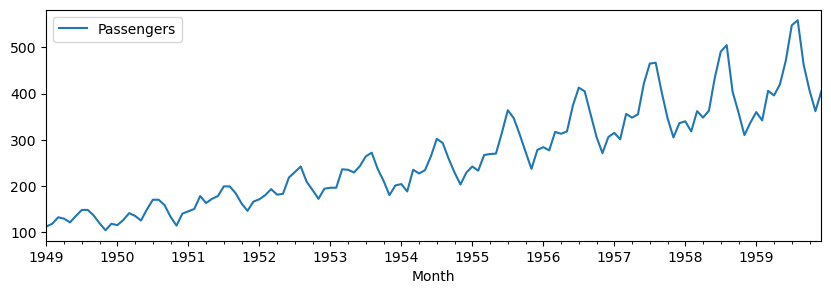

In [31]:
df.plot(figsize=(10,3))

## Autocorrelation과 ACF

### Autocorrelation

자기 상관이란 현재 시점의 값과 특정한 시차(lag)를 가진 값 간의 상관관계입니다. 이 때 유의미한 자기 상관을 갖는다는 것은 이전 시점의 값이 현재 시점의 값을 예측하는데 도움이 된다는 의미입니다.

auto correlation의 측정은 현재 시점의 값과 특정 시차 이전 값 간의 pearson correlation을 측정하면 됩니다.

In [32]:
# 1~5 시점 전의 값 따로 컬럼으로 만들기 
df["lag1"] = df["Passengers"].shift(1)
df["lag2"] = df["Passengers"].shift(2)
df["lag3"] = df["Passengers"].shift(3)
df["lag4"] = df["Passengers"].shift(4)
df["lag5"] = df["Passengers"].shift(5)

In [33]:
df

,Passengers,lag1,lag2,lag3,lag4,lag5
Month,,,,,,
1949-01-01,112,NaN,NaN,NaN,NaN,NaN
1949-02-01,118,112.0,NaN,NaN,NaN,NaN
1949-03-01,132,118.0,112.0,NaN,NaN,NaN
1949-04-01,129,132.0,118.0,112.0,NaN,NaN
1949-05-01,121,129.0,132.0,118.0,112.0,NaN
...,...,...,...,...,...,...
1959-08-01,559,548.0,472.0,420.0,396.0,406.0
1959-09-01,463,559.0,548.0,472.0,420.0,396.0
1959-10-01,407,463.0,559.0,548.0,472.0,420.0


In [34]:
import numpy as np

for i in range(1,6):
    target_column = f"lag{i}"
    target_df = df[["Passengers", target_column]].dropna()
    mat = np.corrcoef(target_df["Passengers"], target_df[target_column])
    auto_correlation = mat[0][1]
    print(f"lag {i} auto correlation: {auto_correlation}")

# auto correlation 이 높으면 이전 값과 상관 관계가 높다 = 이전 갑이 높으면 이후도 높고
# 시간이 길어짐에 따라 당연히 auto correlation은 낮아질 수밖에 없음

lag 1 auto correlation: 0.9564126401174388
lag 2 auto correlation: 0.8872358567005801
lag 3 auto correlation: 0.8253839252373406
lag 4 auto correlation: 0.7848669672734249
lag 5 auto correlation: 0.7750525012693907


In [35]:
print(mat)

[[1.        0.7750525]
 [0.7750525 1.       ]]


### Auto Correlation Function

시차를 늘려가며 자기 상관을 계산하는 함수를 Auto Correlation Function이라고 부릅니다. 

파란색 영역은 주로 자기상관 함수 값이 통계적으로 유의미하게 0과 다른지를 나타내기 위해 사용됩니다. 통계적으로 유의미한 영역을 초과하는 ACF 값들은 해당 시차(lag)에서 자기상관이 존재한다는 것을 의미합니다. 반대로 파란색 영역 안에 포함되는 경우에는 해당 시차에서 자기상관이 없다고 볼 수 있습니다.

추가로 ACF에서 주기적인 spike가 관찰되면 데이터가 계절성을 띈다고 볼 수 있습니다.

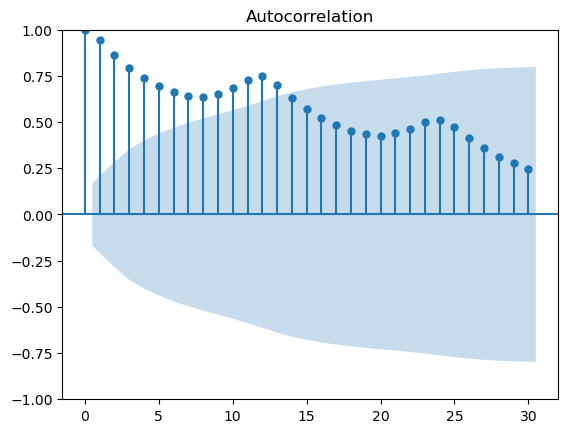

In [40]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df["Passengers"], lags=30);

# spike가 띈다 = 이 데이터가 계절성을 띈다
# 시간이 흘러감에 따라 상관관계는 낮아지지만 계절성에 따라 주기적으로 spike가 띔

## Partial Autocorrelation과 PACF

### Partial Autocorrelation
Partial Autocorrelation은 Auto Correlation과 비슷한 정보를 전달하지만, 중간에 끼어있는 lag들의 영향을 제외한 순수한 현재 시점의 값과 특정 시차 이전 값간의 상관관계를 계산합니다. 

먼저 lag 1일 때는 중간에 끼인 lag들이 없기 때문에 auto correlation과 동일한 값을 갖습니다.

$$\phi_{1,1}=corr(z_{t+1},z_{t}),\text{for k=1}$$

그 이후부터는 중간에 끼어있는 lag들의 영향을 제외한 다음, correlation을 계산합니다. 예를들어 lag5의 partial auto correlation을 측정하고 싶다면 중간에 끼어있는 lag1, lag2, lag3, lag4의 영향을 제거해준 다음 correlation을 계산하는 것입니다.

$$\phi_{k,k}=corr(z_{t+k}-\hat{z}_{t+k},z_{t}-\hat{z}_{t}),\text{for k ≥ 2}$$

수식을 보면 중간에 끼어있는 lag들의 영향을 제거하기 위해서 z_t+k와 z_t를 각각 z^_t+k와 z^t를 빼주었습니다. 이는 각각 중간에 끼어있는 lag 값들로 다중 선형 회귀식을 만들어서 예측한 값들입니다.

$$\hat{z}_{t+k}=\beta_{1}z_{t+k-1}+...+\beta_{k-1}z_{t+1}$$

$$\hat{z}_{t}=\beta_{1}z_{t+1}+...+\beta_{k-1}z_{t+k-1}$$

Partial Auto Correlation에 대해서 더 궁금하신 분들은 아래 아티클을 참고해주세요.  
https://hongl.tistory.com/67

In [37]:
# 핵심은 중간에 끼어있는 alg로 다중 선형 회귀시을 만들고 그로부터 얻은 예측값을 빼주기

### PACF

시차를 늘려가며 PAC를 계산하는 함수를 Partial Auto Correlation Function이라고 부릅니다. 마찬가지로 파란색 영역 밖에 PAC 값이 위치하면 PAC가 존재하는 것이고, 영역 안에 위치하면 PAC가 존재하지 않는 것으로 해석할 수 있습니다.

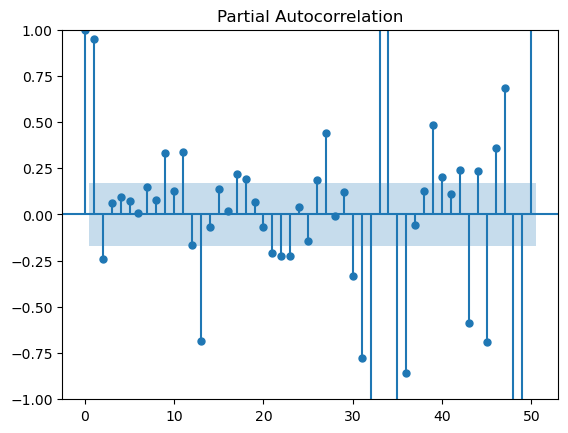

In [43]:
from statsmodels.graphics.tsaplots import plot_pacf

plot_pacf(df["Passengers"], lags=50, method="yw");

## 정리

이번 챕터에서는 ACF와 PACF의 개념에 대해서 배우고, 직접 플랏을 그려보았습니다. 이는 뒤에 이어지는 ARIMA 모델을 이해하기 위해서 반드시 필요한 개념이므로 핵심 개념을 잘 기억해두시고 넘어가면 좋겠습니다.